In [1]:
import Heston
import BlackScholes
import pandas as pd
import numpy as np
import QuantLib as ql
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint
from scipy.optimize import least_squares
import scipy.integrate
import time

In [2]:
tck = 'SPY'
number = 13

def open_files(main_path, number, year) -> dict: 
    opt_chains = dict()
    last_month = ''
    for i in range(1, number+1):
        file_name = main_path + '/exp (' + str(i) + ').csv'
        aux = pd.read_csv(file_name, index_col = 0)[['expiryDate','c_Last','c_Bid','c_Ask', 'c_Volume', 'c_Openinterest', 'strike']]
        aux.columns = ['expiryDate','last','bid','ask', 'volume', 'openinterest', 'strike']
        
        expiration = aux.iloc[0].expiryDate.split()
        
        months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
                 'Jul':7,'Aug':8, 'Sep':9 ,'Oct':10, 'Nov':11,'Dec':12}
        
        curr_month = months[expiration[0]]        
        if last_month == 12 and curr_month == 1:
            year += 1            
        last_month = curr_month 
        
        opt_chains[ql.Date(int(expiration[1]), curr_month, year)] = aux.drop(columns = 'expiryDate')
        del aux
        
    return opt_chains

In [3]:
opt_chains = open_files('SPY_OPT', number, 2022)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
tomorrow = datetime.datetime(2022, 9, 14)
today = ql.Date(13, 9, 2022)   # referencing starting date
r = 0.0291
q = 0.0154
S0 = 393.1000061035156
mat = list(opt_chains.keys())
df = opt_chains[mat[-1]]
T = (mat[-1] - today)/365
df['mid'] = (df['bid'] + df['ask'])/2
df = df[df['strike'] > S0]
# df = df[df['strike'] % 5 == 0]
# df = df[df['last'] < df['ask']]
# df = df[df['last'] > df['bid']]

K = np.array(df['strike']).flatten()
P = np.array(df['mid']).flatten() 
N = 64
L = 12
options_type = np.ones(len(K))

<IPython.core.display.Javascript object>


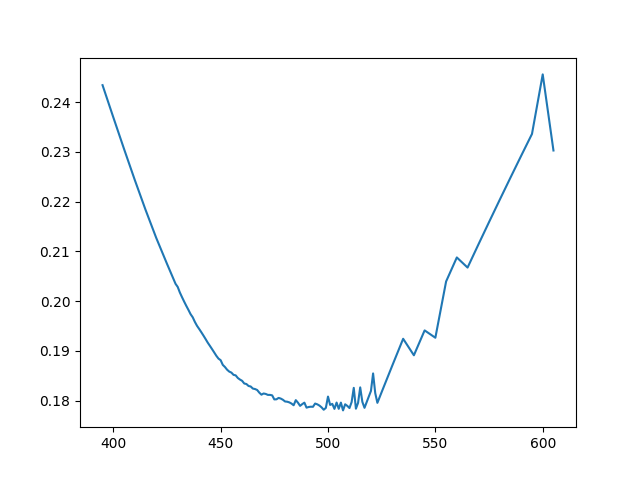

In [4]:
%matplotlib notebook
IV = BlackScholes.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-10)
plt.plot(K,IV)
plt.show()

In [6]:
start_time = time.time()

params = np.array([.2, .5, .2, .3, -.8])

def f(prms):
    sigma_0, kappa,eta, theta, rho = prms
    precomp, a, b = Heston.precomputed_terms(r, q, T, sigma_0, kappa, eta, theta, rho, L, N)
    P_cal = Heston.cos_method_Heston_LF(precomp, a, b, T, r, q, sigma_0, kappa, eta, theta, \
                                        rho, S0, K, N, options_type, L)  
    err = P_cal - P
    return err

def j(prms):
    sigma_0, kappa,eta, theta, rho = prms
    return Heston.grad_c(T, K, sigma_0, kappa, eta, theta, rho, S0, r, q, 60, -1, 100)

bnds = ([1e-10,1e-10,1e-10,1e-10,-1.], [np.inf,np.inf,np.inf,np.inf,0.])
min_ = least_squares(f, x0 = params, bounds = bnds, verbose = 2)
print(f'Time to run: {time.time() - start_time: .0f} s')

sigma_0, kappa, eta, theta, rho = min_.x
print(f'Calibrated parameters:\tkappa:{ kappa: .3f}\tsigma_0:{ sigma_0: .3f}\teta:{ eta: .3f}\ttheta:{ theta: .3f}\trho: {rho:.3f}')
P_cal = Heston.analytic_hest(S0, K, T, r, q, kappa, theta, rho, eta, sigma_0, options_type)
IV_cal = BlackScholes.BSImpliedVol(S0, K, T, r, q, P_cal, Option_type = 1, toll = 1e-5)

print(f'Feller condition: {2*kappa*eta - theta**2}')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5803e+03                                    1.80e+04    
       1              2         5.4241e+02      7.04e+03       1.20e+00       2.98e+03    
       2              3         6.1613e+01      4.81e+02       7.91e-01       6.06e+02    
       3              4         1.0799e+01      5.08e+01       1.43e-01       4.85e+01    
       4              5         5.3288e+00      5.47e+00       2.05e+00       2.54e+02    
       5              6         2.5238e+00      2.80e+00       2.63e-01       1.60e+02    
       6              7         2.2192e+00      3.05e-01       8.51e-02       7.04e+00    
       7             10         1.6031e+00      6.16e-01       2.77e-01       1.09e+01    
       8             11         1.5927e+00      1.04e-02       1.28e-03       5.65e+00    
       9             12         6.7370e-01      9.19e-01       5.27e-01       1.10e+02    

      91             114        2.2021e-03      7.27e-06       1.44e-01       5.81e-01    
      92             115        2.2012e-03      8.60e-07       1.90e-05       6.53e-03    
      93             116        2.2011e-03      8.76e-08       2.90e-01       2.12e+00    
      94             117        2.1902e-03      1.09e-05       8.41e-06       1.28e-02    
      95             118        2.1876e-03      2.61e-06       6.48e-02       2.62e-02    
      96             119        2.1876e-03      5.30e-09       1.71e-06       5.38e-03    
      97             120        2.1859e-03      1.74e-06       7.45e-02       1.35e-01    
      98             121        2.1858e-03      4.70e-08       1.95e-06       4.27e-03    
      99             122        2.1839e-03      1.93e-06       1.50e-01       5.01e-01    
      100            123        2.1833e-03      5.95e-07       8.94e-06       5.98e-03    
      101            124        2.1822e-03      1.12e-06       1.13e-01       1.06e-01    

<IPython.core.display.Javascript object>


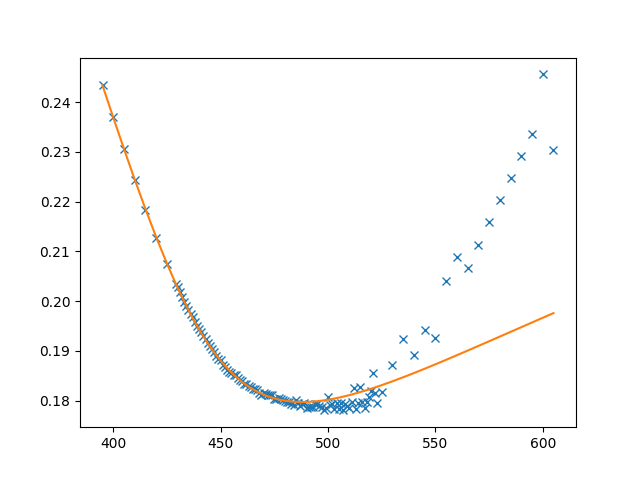

err = 0.11733976054718497	 err_IV = 0.01596401899612406


In [7]:
%matplotlib notebook

plt.plot(K,IV, 'x')
plt.plot(K,IV_cal)
plt.show()

err = np.linalg.norm((P-P_cal)/P, 1)/len(K)
err_IV = np.linalg.norm((IV-IV_cal)/IV, 1)/len(K)
print(f'err = {err}\t err_IV = {err_IV}')

<IPython.core.display.Javascript object>


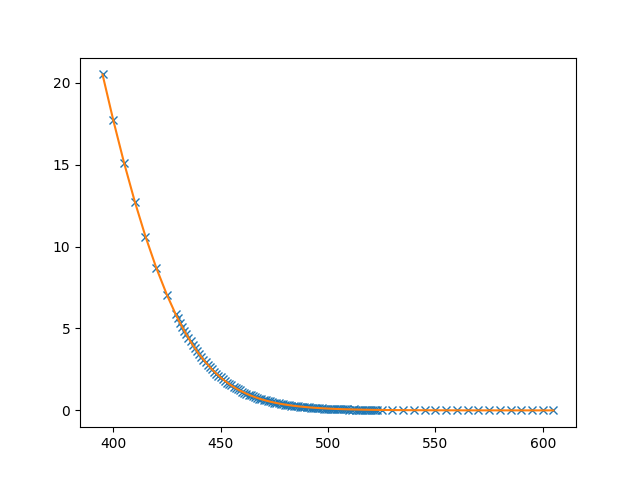

In [8]:
%matplotlib notebook

plt.plot(K,P, 'x')
plt.plot(K,P_cal)
plt.show()